# Netflix recommendation engine

Based on the [netflix prize dataset](https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data). Our
goal is to build a recommendation engine.

## Importing the libraries

In [174]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import sleep
import sqlite3
import requests
import json

## Connect to database

Here we connect to the database `netflix_dev.db`. Currently, we are using a small portion of the whole dataset, around 100.000 / 100.000.000 Entries. This is due to the fact that the whole dataset is too big to be processed on a normal computer. We are using a sample of 100.000 entries to test our code and to get a first impression of the data. The sample is randomly chosen, so it is representative for the whole dataset.

- `netflix_data` contains the ratings from the netflix prize challenge.
- `movie_titles` contains the titles corresponding to the `film` column in `netflix_data`
- `combined` is a join of `netflix_data` and `movie_titles` over the `film` column.

In [175]:
# small size for testing
db_dev_path = 'netflix_dev.db'
db_dev_conn = 'sqlite://' + db_dev_path

# full size for production
db_prod_path = 'netflix.db'
db_prod_conn = 'sqlite://' + db_prod_path

In [194]:
netflix_data = pl.read_database("SELECT * FROM netflix_data", db_prod_conn)
movie_titles = pl.read_database("SELECT * FROM movie_titles", db_dev_conn)
# combined     = pl.read_database("SELECT * FROM netflix_data, movie_titles \
#                                   WHERE netflix_data.film = movie_titles.film", db_prod_path)

In [196]:
# take only 10.000.000 rows for testing
# skip this to use all 100.000.000 rows
netflix_data = netflix_data.sample(10000000)

In [197]:
# the number of ratings
len(netflix_data)

10000000

In [180]:
# return the title for a given item_id (column film)
# i.e. get_title(16242) -> "Con Air"
def get_title(item_id):
    return movie_titles.filter(pl.col("film") == item_id)["title"].to_list()[0]

## Run some queries

Now we run some queries on the data.
- `most_rated` contains the 100 most rated movies.
- `best_rated` contains the 100 best rated movies that have at least 50 ratings.
- `not_rated` contains all movies that have no ratings.
- `rated` contains all movies that have at least one rating.

In [198]:
most_rated = pl.read_database("SELECT netflix_data.film, COUNT(*) AS 'num_ratings', AVG(netflix_data.rating) AS 'avg_rating' \
                               FROM netflix_data \
                               GROUP BY netflix_data.film \
                               ORDER BY num_ratings DESC \
                               LIMIT 100 \
                               ", db_prod_conn)

most_rated

film,num_ratings,avg_rating
i64,i64,f64
5317,232944,3.361267
15124,216596,3.724238
14313,200832,3.783854
15205,196397,3.442166
1905,193941,4.153908
6287,193295,3.905047
11283,181508,4.29991
16377,181426,4.306941
16242,178068,3.454411


In [199]:
best_rated = pl.read_database("SELECT netflix_data.film, COUNT(*) AS 'num_ratings', AVG(netflix_data.rating) AS 'avg_rating' \
                                FROM netflix_data \
                                GROUP BY netflix_data.film \
                                HAVING num_ratings > 25  \
                                ORDER BY AVG(netflix_data.rating) DESC \
                                LIMIT 100", db_prod_conn)

best_rated

film,num_ratings,avg_rating
i64,i64,f64
14961,73335,4.72327
7230,73422,4.716611
7057,74912,4.702611
3456,7249,4.670989
9864,1747,4.638809
15538,1633,4.605021
14791,75,4.6
10464,89,4.595506
14550,139660,4.593384


In [9]:
rated = pl.read_database("SELECT movie_titles.film, movie_titles.title \
                          FROM movie_titles \
                          WHERE movie_titles.film IN (SELECT film FROM netflix_data)",  db_dev_conn)

not_rated = pl.read_database("SELECT movie_titles.film, movie_titles.title \
                              FROM movie_titles \
                              WHERE movie_titles.film NOT IN (SELECT film FROM netflix_data)",  db_dev_conn)

rated

film,title
i64,str
1,"""Dinosaur Plane…"
2,"""Isle of Man TT…"
3,"""Character"""
6,"""Sick"""
8,"""What the #$*! …"
10,"""Fighter"""
12,"""My Favorite Br…"
13,"""Lord of the Ri…"
15,"""Neil Diamond: …"


# Getting the movie metadata

We use the [OMDb API](http://www.omdbapi.com/) to get the movie metadata and store the metadata in the `movie_metadata` table.

In [8]:
# TODO: PLEASE DELETE BEFORE PUBLIC RELEASE
api_key = "75eaf570"

# get movie data from the omdb api
#
# input: title of movie (str)
#
# output: json object of movie data
#         title, year, rated, release date, runtime, genre, language, country, ratings from different sites, ...
def ombd_api(title):

    url = "http://www.omdbapi.com/?apikey=" + api_key + "&t=" + title
    response = requests.get(url)
    data = json.loads(response.text)

    return data

Now we want to get the movie metadata for every single movie. First, we get all movie titles from the `movie_titles` table. Then we iterate over the movie titles and get the metadata for each movie. We store the metadata in a csv file.

In [9]:
fields = [
    'Year',
    'Response',
    'Rated',
    'Released',
    'Runtime',
    'Genre',
    'Director',
    'Writer',
    'Actors',
    'Plot',
    'Language',
    'Country',
    'Awards',
    'Poster',
    'Ratings',
    'Metascore',
    'imdbRating',
    'imdbVotes',
    'imdbID',
    'Type',
    'DVD',
    'BoxOffice',
    'Production',
    'Website',
]

In [10]:
# CAN BE SKIPPED
titles = rated["title"].to_list()

# get movie data for all rated movies
movie_data = []

for title in tqdm(titles):

    response = ombd_api(title)
    current_data = {}

    # try to copy all value to all fields
    for field in fields:

        current_data["Title"] = title

        # is the current field in the response?
        # if yes -> copy the value from the response
        # if no  -> set the value to "N/A"
        if(field not in response):
            current_data[field] = "N/A"
        else:
            current_data[field] = response.get(field)

    movie_data.append(current_data)

    sleep(0.1)

# movie_data = pd.DataFrame(movie_data)
# movie_data.to_csv("data/movie_data.csv", sep="|")

  0%|          | 7/9235 [00:03<1:07:47,  2.27it/s]


KeyboardInterrupt: 

In [ ]:
# how many responses are in df?
# we take the sum of the column "Response"
responses = df["Response"]
responses_sum = 0

for response in responses:
    if(response == "True"):
        responses_sum += 1

print("Data found:", responses_sum)
print("    Movies:", len(responses)) 
print("   Percent:", responses_sum/ len(responses))

Data found: 7209
    Movies: 9235
   Percent: 0.7806172171088251


In [16]:
movie_data = pd.read_csv("data/movie_data.csv", sep="|")
movie_data

,Unnamed: 0,Title,Year,Response,Rated,Released,Runtime,Genre,Director,Writer,...,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website
0,0,Dinosaur Planet,2003–,True,Not Rated,14 Dec 2003,50 min,"Documentary, Animation, Family",NaN,NaN,...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.7,531,tt0389605,series,NaN,NaN,NaN,NaN
1,1,Isle of Man TT 2004 Review,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Character,1997,True,R,27 Mar 1998,122 min,"Crime, Drama, Mystery",Mike van Diem,"Ferdinand Bordewijk, Laurens Geels, Mike van Diem",...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.7,"11,037",tt0119448,movie,04 Feb 2003,"$623,983",NaN,NaN
3,3,Sick,2022,True,R,13 Jan 2023,83 min,"Horror, Thriller",John Hyams,"Kevin Williamson, Katelyn Crabb",...,"[{'Source': 'Internet Movie Database', 'Value'...",62.0,6.1,"12,303",tt14642626,movie,13 Jan 2023,NaN,NaN,NaN
4,4,What the #$*! Do We Know!?,2017,True,NaN,04 Oct 2017,97 min,Documentary,"Kip Andersen, Keegan Kuhn","Kip Andersen, Keegan Kuhn",...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.2,"29,844",tt5541848,movie,16 Jun 2017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9230,9230,Shakespeare in Love,1998,True,R,08 Jan 1999,123 min,"Comedy, Drama, History",John Madden,"Marc Norman, Tom Stoppard",...,"[{'Source': 'Internet Movie Database', 'Value'...",87.0,7.1,"228,514",tt0138097,movie,07 Dec 1999,"$100,317,794",NaN,NaN
9231,9231,Fidel Castro: American Experience,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9232,9232,Epoch,2001,True,PG-13,24 Nov 2001,96 min,"Sci-Fi, Thriller",Matt Codd,"Jonathan Raymond, Phillip J. Roth",...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.8,"2,474",tt0233657,movie,25 Aug 2005,NaN,NaN,NaN
9233,9233,The Company,2003,True,PG-13,07 May 2004,112 min,"Drama, Music, Romance",Robert Altman,"Neve Campbell, Barbara Turner",...,"[{'Source': 'Internet Movie Database', 'Value'...",73.0,6.2,"6,708",tt0335013,movie,01 Jun 2004,"$2,283,914",NaN,NaN


# Create a recommendation engine

Now we create a recommendation engine. We use the `surprise` library for this. We use the `SVD` algorithm, which is a matrix factorization algorithm. We use the `trainset` to train the algorithm and the `testset` to test the algorithm. We use the `RMSE` as a metric to evaluate the algorithm.

In [10]:
import surprise
from surprise import Dataset, KNNBasic, Reader, accuracy, SVD
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

First we need to bring the ratings data in the correct format. `Surprise` expects a dataframe of format `[user_ids, itemd_ids, ratings]`, so we need to drop the `date` column. We also need to convert the polars dataframe to a pandas dataframe, because surprise does not support polars dataframes. Finally, we can create the `Dataset` and the `trainset` and `testset` (75% training, 25% testing).

In [200]:
netflix_data

film,user,rating,date
i64,i64,i64,str
5187,1490510,1,"""2004-03-02 """
4977,2457405,2,"""2005-11-02 """
17355,1899429,4,"""2005-05-04 """
16384,276116,4,"""2005-12-04 """
6343,2173862,1,"""2003-03-26 """
5345,1259337,5,"""2005-10-28 """
16272,1280168,5,"""2004-04-06 """
11089,1164246,4,"""2005-04-26 """
16660,2560486,3,"""2005-07-17 """


In [281]:
# remove movies with less than 100 ratings

# get the number of ratings for each movie
pre_ratings = netflix_data.groupby("film").count()

# keep only movies with at least 100 ratings
pre_ratings = pre_ratings.filter(pl.col("count") >= 200)

# join the dataframes
pre_ratings = netflix_data.join(pre_ratings, on="film", how="inner")

# bring the ratings into a format that surprise can work with
ratings = pre_ratings.drop("date").drop("count")
ratings

film,user,rating
i64,i64,i64
5187,1490510,1
4977,2457405,2
17355,1899429,4
16384,276116,4
6343,2173862,1
5345,1259337,5
16272,1280168,5
11089,1164246,4
16660,2560486,3


In [282]:
# remove users with less than 50 ratings

# get the number of ratings for each user
pre_users = ratings.drop("film").drop("rating").groupby("user").count()

# keep only users with at least 50 ratings
pre_users = pre_users.filter(pl.col("count") >= 25)

# join the dataframes
ratings = ratings.join(pre_users, on="user").drop("count")
ratings

film,user,rating
i64,i64,i64
5187,1490510,1
6343,2173862,1
16660,2560486,3
9882,168975,4
5092,2198123,4
11647,514520,4
12818,1249433,3
14160,1256263,1
6523,1566875,3


In [283]:
# average rating for each user
avg_rating_user = ratings.groupby("user").mean().sort(pl.col("rating")).drop("film")

# average rating for each movie
avg_rating_film = ratings.groupby("film").mean().sort(pl.col("rating")).drop("user")

# Count of ratings for each movie
film_rating_counts = ratings.groupby("film").agg(
    [
        pl.count("rating").alias("count")
    ]
)

# Count of ratings for each user
user_rating_counts = ratings.groupby("user").agg(
    [
        pl.count("rating").alias("count")
    ]
)

avg_rating_film = avg_rating_film.join(film_rating_counts, on="film")
avg_rating_user = avg_rating_user.join(user_rating_counts, on="user")

In [284]:
# global average rating
global_avg_rating = ratings["rating"].mean()

# Variance of individual movie ratings
Vb = ratings["rating"].var()

# Variance of all movies' average ratings
Va = avg_rating_film["rating"].var()

# Shrinkage factor
K = Vb/Va # This can be adjusted, Simon Funk mentioned K=25 works well

# Apply shrinkage to movie averages
avg_rating_film = avg_rating_film.with_columns([
    ((global_avg_rating * K + avg_rating_film["rating"] * avg_rating_film["count"]) / (K + avg_rating_film["count"])).alias("adjusted_rating")
])

# Do the same for user averages
avg_rating_user = avg_rating_user.with_columns([
    ((global_avg_rating * K + avg_rating_user["rating"] * avg_rating_user["count"]) / (K + avg_rating_user["count"])).alias("adjusted_rating")
])

ratings = ratings.join(avg_rating_user, on="user", suffix="_user")
ratings = ratings.join(avg_rating_film, on="film", suffix="_film")

ratings

film,user,rating,rating_user,count,adjusted_rating,rating_film,count_film,adjusted_rating_film
i64,i64,i64,f64,u32,f64,f64,u32,f64
5187,1490510,1,2.92,50,2.997309,3.630519,1291,3.630328
6343,2173862,1,3.657143,35,3.647001,3.240618,906,3.243122
16660,2560486,3,3.670588,85,3.665034,3.71748,984,3.716659
9882,168975,4,4.24,25,4.106423,3.798319,5355,3.79807
5092,2198123,4,3.149485,194,3.163834,4.377732,961,4.372458
11647,514520,4,3.73913,46,3.720968,3.336391,1308,3.337656
12818,1249433,3,2.797101,69,2.865529,3.573937,2563,3.573983
14160,1256263,1,3.258065,31,3.315979,3.561728,162,3.562909
6523,1566875,3,3.271739,92,3.292885,3.401354,1034,3.402546


In [286]:
# Change the rating column here to use adjusted ratings
final_ratings = ratings.with_columns(
    (pl.col("rating") - global_avg_rating).alias("rating")
)

# Find min and max ratings after normalization
# min_rating = final_ratings["rating"].min()
# max_rating = final_ratings["rating"].max()

# Scaling the ratings to -5 to 5 range
# final_ratings = final_ratings.with_columns(
#     ((pl.col("rating") - min_rating) / (max_rating - min_rating)) * 10 - 5
# )

final_ratings

film,user,rating,rating_user,count,adjusted_rating,rating_film,count_film,adjusted_rating_film
i64,i64,f64,f64,u32,f64,f64,u32,f64
5187,1490510,-2.592355,2.92,50,2.997309,3.630519,1291,3.630328
6343,2173862,-2.592355,3.657143,35,3.647001,3.240618,906,3.243122
16660,2560486,-0.592355,3.670588,85,3.665034,3.71748,984,3.716659
9882,168975,0.407645,4.24,25,4.106423,3.798319,5355,3.79807
5092,2198123,0.407645,3.149485,194,3.163834,4.377732,961,4.372458
11647,514520,0.407645,3.73913,46,3.720968,3.336391,1308,3.337656
12818,1249433,-0.592355,2.797101,69,2.865529,3.573937,2563,3.573983
14160,1256263,-2.592355,3.258065,31,3.315979,3.561728,162,3.562909
6523,1566875,-0.592355,3.271739,92,3.292885,3.401354,1034,3.402546


In [287]:
# load the data into a surprise dataset
final_ratings = final_ratings[["user", "film", "rating"]]
pd_ratings = final_ratings.to_pandas()

data = Dataset.load_from_df(pd_ratings, Reader(rating_scale=(-5, 5)))  # Note the adjusted scale

In [212]:
pd_ratings.describe()

,user,film,rating
count,6.680097e+06,6.680097e+06,6.680097e+06
mean,1.321057e+06,9.041971e+03,7.722609e-02
std,7.645980e+05,5.126032e+03,1.261756e+00
min,6.000000e+00,3.000000e+00,-5.000000e+00
25%,6.601750e+05,4.661000e+03,-7.009537e-01
50%,1.316671e+06,8.989000e+03,1.926633e-01
75%,1.982967e+06,1.359300e+04,9.669058e-01
max,2.649426e+06,1.776900e+04,5.000000e+00


In [259]:
# free some memory
del pre_ratings, pre_users, ratings, avg_rating_film, avg_rating_user, film_rating_counts, user_rating_counts, final_ratings, pd_ratings

In [288]:
# build trainset and testset
# WARNING: for the full set, this takes a lot of memory
trainset, testset = train_test_split(data, test_size=0.25)
trainset_data = trainset.build_testset()

In [214]:
# all of the available algorithms from surprise
algorithms = [

    surprise.NormalPredictor(),
    surprise.BaselineOnly(),
    #surprise.KNNBasic(),
    #surprise.KNNWithMeans(),
    #surprise.KNNWithZScore(),
    #surprise.KNNBaseline(),
    surprise.SVD(),
    surprise.SVDpp(),
    surprise.NMF(),
    # surprise.SlopeOne(), (takes too much memory)
    surprise.CoClustering(),

]

We choose the SVD algorithm and fit it to the dataset. Then we predict the ratings for the testset and calculate the RMSE.

In [215]:
for algo in algorithms:

    print(algo.__class__.__name__)

    algo.fit(trainset)
    predictions = algo.test(testset, verbose=False)
    print("RMSE:", accuracy.rmse(predictions, verbose=False))
    print("MAE:", accuracy.mae(predictions, verbose=False))
    print()

NormalPredictor


KeyboardInterrupt: 

In [29]:
# test grid search for SVD
# Define the parameter grid.
param_grid = {
    'n_epochs': [20, 40, 60, 100], 
    'n_factors': [50, 100, 150], 
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Run grid search.
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

best_params = gs.best_params['rmse']

# Get best parameters.
print(best_params)

{'n_epochs': 100, 'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [289]:
# use best parameters to train the model
algo = surprise.SVD(
    n_epochs=best_params['n_epochs'],
    n_factors=100,#best_params['n_factors'],
    lr_all=0.001,#best_params['lr_all'],
    reg_all=best_params['reg_all']
    )
algo.fit(trainset)

In [290]:
predictions = algo.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions, verbose=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAE
mae = accuracy.mae(predictions, verbose=False)
print("Mean Absolute Error (MAE):", mae)

Root Mean Squared Error (RMSE): 0.9083624965467972
Mean Absolute Error (MAE): 0.716118754748525


In [90]:
algo.pu, algo.qi

(array([[-0.27647239,  0.01348299, -0.10657002, ...,  0.00252294,
         -0.05059938,  0.07530136],
        [-0.05886018, -0.11874914, -0.01830654, ...,  0.03291193,
          0.01347081,  0.04612174],
        [ 0.03940495, -0.08663467,  0.09503358, ..., -0.01524089,
         -0.21307783, -0.22164593],
        ...,
        [ 0.06833477,  0.07719757, -0.12811402, ..., -0.07790776,
         -0.0195908 , -0.07534056],
        [-0.01359763, -0.16542536, -0.00275329, ...,  0.01051972,
         -0.23955737, -0.02332987],
        [ 0.15995708,  0.13565628, -0.09224276, ..., -0.03504744,
         -0.0669543 , -0.04116062]]),
 array([[-0.24664426, -0.09950425, -0.02451378, ...,  0.28646938,
         -0.13992573, -0.13674779],
        [ 0.20510766,  0.02772634,  0.01143176, ...,  0.02706853,
          0.20774544, -0.18348203],
        [-0.26828558, -0.07073919,  0.31467226, ..., -0.31193004,
         -0.29516042,  0.15073055],
        ...,
        [-0.05239879, -0.12587537, -0.05339419, ...,  

In [74]:
factors = []
movies = []

for i in range(20):
    film = best_rated[i]['film'][0]
    title = best_rated[i]['title'][0]
    avg_rating = best_rated[i]['avg_rating'][0]

    # print(film + "," + title + "," + avg_rating)
    # print(algo.qi[i+1])

    factors.append(algo.qi[film-1])
    movies.append(title)

ColumnNotFoundError: title

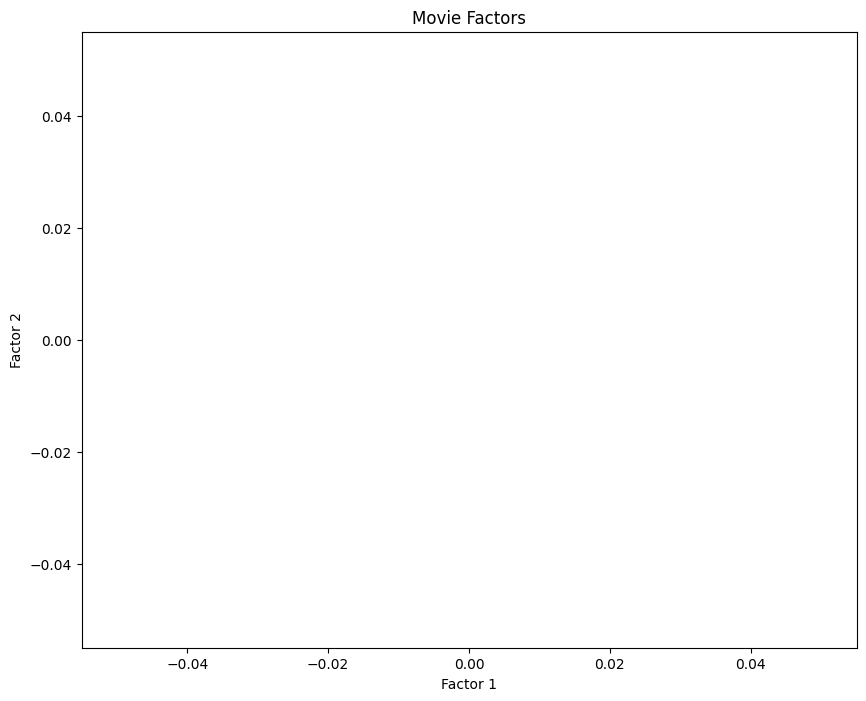

In [75]:
import matplotlib.pyplot as plt

x = [factor[0] for factor in factors]
y = [factor[1] for factor in factors]

plt.figure(figsize=(10, 8))
plt.scatter(x, y)

for i, txt in enumerate(movies):
    plt.annotate(txt, (x[i], y[i]))
    print(i, txt)

plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Movie Factors')
plt.show()

In [76]:
def euclidean_distance(p, q):
    return np.sqrt(np.sum((p - q) ** 2))

In [77]:
point1 = factors[0]

for i in range(20):
    point2 = factors[i]
    distance = euclidean_distance(point1, point2)
    print(i, distance, movies[i])
    euclidean_distance(point1, point2)

IndexError: list index out of range

In [116]:
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9452  0.9434  0.9441  0.9457  0.9476  0.9452  0.0015  
MAE (testset)     0.7549  0.7529  0.7548  0.7556  0.7579  0.7552  0.0016  
Fit time          22.62   22.42   22.10   21.93   22.13   22.24   0.25    
Test time         0.92    0.53    0.53    0.54    0.85    0.67    0.17    


{'test_rmse': array([0.94517688, 0.94341497, 0.94407548, 0.9456979 , 0.94763632]),
 'test_mae': array([0.75487736, 0.7528779 , 0.75481556, 0.75561   , 0.75790107]),
 'fit_time': (22.616572380065918,
  22.4216468334198,
  22.104206800460815,
  21.926141262054443,
  22.13098955154419),
 'test_time': (0.9161112308502197,
  0.5252621173858643,
  0.5277433395385742,
  0.5411357879638672,
  0.8501431941986084)}

In [150]:
def random_predict(user_id = None, item_id = None):
    # get two random indices from the trainset_data
    i_1 = np.random.randint(0, len(trainset_data))
    i_2 = np.random.randint(0, len(trainset_data))

    # take the user_id from i_1
    # take the item_id from i_2
    if user_id == None:
        user_id = trainset_data[i_1][0]

    if item_id == None:
        item_id = trainset_data[i_2][1]

    # predict how user_id will rate item_id
    pred = algo.predict(user_id, item_id)

    return pred

In [291]:
# print prediction information in a pretty string
def pretty_predict(pred):
    user_id = pred.uid
    item_id = pred.iid
    pred_rating = pred.est

    title = get_title(item_id)

    # fit pred_rating into the rating scale
    #pred_rating = (pred_rating + 5) / 2
    pred_rating = pred_rating + global_avg_rating

    print(user_id, "will rate", title, "with", pred_rating, "stars.")

    # title = get_title(item_id)

    # print("User {0} will rate {1} ({2}) with {3} stars.".format(user_id, title, item_id, pred_rating))

Now we can predict some ratings. Right now it returns the mean of 0 almost every time (i dont know why)

In [292]:
for i in range(10):
    pred = random_predict(user_id = 2118461)
    pretty_predict(pred)

2118461 will rate Midnight Run with 4.491221246697408 stars.
2118461 will rate Solaris with 3.3724385193078783 stars.
2118461 will rate Gone in 60 Seconds with 4.116530738028726 stars.
2118461 will rate Star Wars: Episode II: Attack of the Clones with 4.238862011760599 stars.
2118461 will rate The Princess Diaries (Widescreen) with 4.214091598658883 stars.
2118461 will rate Forever Young with 4.121387761517652 stars.
2118461 will rate Paycheck with 4.091645953811306 stars.
2118461 will rate Behind the Sun with 4.18029243216413 stars.
2118461 will rate Enemy at the Gates with 4.485291168200306 stars.
2118461 will rate Blazing Saddles with 4.727616696081969 stars.


In [249]:
# find the 5 users with the most ratings
user_rating_counts = ratings.groupby("user").count().sort(by="count", descending=True)
user_rating_counts.head(5)

user,count
i64,u32
2118461,508
387418,507
2439493,500
305344,475
716173,471


In [278]:
# rate all movies for a given user_id
user_id = 1314869

# get all the item_ids in the trainset_data
item_ids = [x[0] for x in trainset_data]

# item_ids should only be unique values
item_ids = list(set(item_ids))

# get a rating for all item_ids from user_id
user_ratings = {}
for item_id in item_ids:
    pred = algo.predict(user_id, item_id)
    user_ratings[item_id] = pred.est

# sort the ratings from highest to lowest
user_ratings = sorted(user_ratings.items(), key=lambda x: x[1], reverse=True)

# print the top 10 movies for user_id
for item_id, rating in user_ratings[:10]:
    title = get_title(item_id)
    print("{0} ({1}) - {2} stars".format(title, item_id, rating))

The Incredibles (10947) - 0.4857166830701662 stars
Police Academy 4: Citizens on Patrol (8372) - 0.4824421169242963 stars
The Sixth Sense (4306) - 0.47549765148343465 stars
The Godfather (12293) - 0.47521035425620783 stars
The Breakfast Club (6797) - 0.4738434456004794 stars
Good Morning, Vietnam (6408) - 0.4723170027024251 stars
Mary Poppins (14185) - 0.47178836954177056 stars
Stargate SG-1: Season 4 (5530) - 0.4716630180073284 stars
The Aristocats (13251) - 0.47057727427681356 stars
Lilo and Stitch 2 (14868) - 0.47001362043463346 stars


In [227]:
# make a user_id rate all most rated movies
user_id = 1314869

for i in range(0, 100):

    film = most_rated[i]["film"][0]
    title = get_title(film)

    pred = algo.predict(user_id, film)

    pretty_predict(pred)

1314869 will rate Miss Congeniality with 2.5514208472680138 stars.
1314869 will rate Independence Day with 2.738014367804042 stars.
1314869 will rate The Patriot with 2.7745343216473675 stars.
1314869 will rate The Day After Tomorrow with 2.5314294854383714 stars.
1314869 will rate Pirates of the Caribbean: The Curse of the Black Pearl with 2.9386763674722034 stars.
1314869 will rate Pretty Woman with 2.8239991030451113 stars.
1314869 will rate Forrest Gump with 2.996545063283089 stars.
1314869 will rate The Green Mile with 3.0269531873014097 stars.
1314869 will rate Con Air with 2.580696876209456 stars.
1314869 will rate Twister with 2.5559815858208252 stars.
1314869 will rate Sweet Home Alabama with 2.603979655778726 stars.
1314869 will rate Pearl Harbor with 2.608119482291581 stars.
1314869 will rate Armageddon with 2.695882449158873 stars.
1314869 will rate The Rock with 2.76246514869831 stars.
1314869 will rate What Women Want with 2.5617456546517556 stars.
1314869 will rate Bruce

In [228]:
# make a user_id rate all best rated movies
user_id = 1314869

for i in range(0, 100):

    film = best_rated[i]["film"][0]
    title = get_title(film)

    pred = algo.predict(user_id, film)

    pretty_predict(pred)

1314869 will rate Lord of the Rings: The Return of the King: Extended Edition with 3.2163175353791407 stars.
1314869 will rate The Lord of the Rings: The Fellowship of the Ring: Extended Edition with 3.1830229789772764 stars.
1314869 will rate Lord of the Rings: The Two Towers: Extended Edition with 3.1726747051004756 stars.
1314869 will rate Lost: Season 1 with 3.260333784419939 stars.
1314869 will rate Battlestar Galactica: Season 1 with 2.6115365539781235 stars.
1314869 will rate Fullmetal Alchemist with 2.6115365539781235 stars.
1314869 will rate Trailer Park Boys: Season 3 with 2.6115365539781235 stars.
1314869 will rate Tenchi Muyo! Ryo Ohki with 2.6115365539781235 stars.
1314869 will rate The Shawshank Redemption: Special Edition with 3.1203337844546266 stars.
1314869 will rate Veronica Mars: Season 1 with 2.6115365539781235 stars.
1314869 will rate Ghost in the Shell: Stand Alone Complex: 2nd Gig with 2.6115365539781235 stars.
1314869 will rate Arrested Development: Season 2 wi

# Evaluation

In [229]:
# get all ratings for a specific user
def get_user_ratings(user_id):
    user_ratings = []

    for rating in trainset_data:
        if rating[0] == user_id:
            user_ratings.append(rating)

    return user_ratings

In [297]:
# predict ratings for all rated movies of a given user
user_ratings = get_user_ratings(387418)
sum_error = 0

for rating in user_ratings:

    # ground truth
    user = rating[0]
    film = rating[1]
    title = get_title(film)
    rating = rating[2]

    # predicted rating
    pred = algo.predict(user, film)
    pred_rating = pred.est

    # error
    error = round((pred_rating - rating) ** 2, 3)
    sum_error += error

    rating = round(rating + global_avg_rating, 1)
    pred_rating = round(pred_rating + global_avg_rating, 1)

    print("{1} ({2}) rated with {3} stars (real {4}, error {5})".format(user, title, film, pred_rating, rating, error))

sum_error = round(sum_error, 3)
avg_error = round(sum_error / len(user_ratings), 3)

print("\nNum Ratings: {0}".format(len(user_ratings)))
print("Sum error: {0}, Avg. error: {1}".format(sum_error, avg_error))

Restoration (5983) rated with 2.0 stars (real 1.0, error 1.018)
Everything You Always Wanted to Know About Sex But Were Afraid to Ask (10367) rated with 2.3 stars (real 1.0, error 1.701)
Absolutely Fabulous: Series 3 (10406) rated with 2.7 stars (real 2.0, error 0.561)
In the Company of Men (9095) rated with 2.2 stars (real 3.0, error 0.659)
The Prince and Me (16406) rated with 2.3 stars (real 3.0, error 0.488)
The Professional (1324) rated with 2.8 stars (real 3.0, error 0.06)
Homeward Bound: The Incredible Journey (9757) rated with 2.4 stars (real 2.0, error 0.137)
The Apple Dumpling Gang Rides Again (3398) rated with 2.4 stars (real 2.0, error 0.151)
The Nightmare Before Christmas (10828) rated with 2.4 stars (real 2.0, error 0.173)
Catch Me If You Can (8644) rated with 2.5 stars (real 5.0, error 6.258)
The Women (1547) rated with 2.7 stars (real 2.0, error 0.558)
Same Time, Next Year (15985) rated with 2.5 stars (real 2.0, error 0.268)
The Godfather (12293) rated with 3.1 stars (re